<a href="https://colab.research.google.com/github/NicholasLeotta99/Neuromatch_BrainCancer/blob/Nick/code/VGG19_Classifier_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Package Imports
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.utils import make_grid
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models
from torchsummary import summary

import os
from google.colab import files
from PIL import Image
import subprocess

import random
random.seed(2023)
print(random.randint(0,10))

6


In [ ]:
# @title Data Loading
print('Upload kaggle.json account information to download the dataset:')
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip -q brain-tumor-mri-dataset.zip

Upload kaggle.json account information to download the dataset:


Saving kaggle.json to kaggle.json
 98% 145M/149M [00:05<00:00, 32.2MB/s]
100% 149M/149M [00:05<00:00, 28.5MB/s]


In [ ]:
# @title Subsampling Validation Data

if not os.path.isdir('./Validation/'):
  os.mkdir('./Validation/')
  classes = os.listdir('./Training/')
  training_samples = []
  for i in classes:
    os.mkdir(f'./Validation/{i}/')
    files = os.listdir(f'./Training/{i}/')
    for f in files:
      training_samples.append(f'/{i}/{f}')
  random.shuffle(training_samples)
  validation_samples = training_samples[0:1100]
  training_samples = training_samples[1100:]
  for samp in validation_samples:
    os.rename(f'./Training{samp}', f'./Validation{samp}')


['/pituitary/Tr-pi_0433.jpg', '/notumor/Tr-no_0705.jpg', '/pituitary/Tr-pi_0405.jpg', '/glioma/Tr-gl_0705.jpg', '/pituitary/Tr-pi_0082.jpg', '/pituitary/Tr-pi_0130.jpg', '/glioma/Tr-gl_1108.jpg', '/glioma/Tr-gl_1140.jpg', '/notumor/Tr-no_0732.jpg', '/notumor/Tr-no_1295.jpg', '/meningioma/Tr-me_0974.jpg', '/notumor/Tr-no_0625.jpg', '/meningioma/Tr-me_0311.jpg', '/notumor/Tr-no_0393.jpg', '/pituitary/Tr-pi_0296.jpg', '/pituitary/Tr-pi_0303.jpg', '/glioma/Tr-gl_0882.jpg', '/glioma/Tr-gl_0536.jpg', '/notumor/Tr-no_0584.jpg', '/meningioma/Tr-me_0843.jpg', '/glioma/Tr-gl_0793.jpg', '/glioma/Tr-gl_0036.jpg', '/meningioma/Tr-me_1238.jpg', '/notumor/Tr-no_0419.jpg', '/notumor/Tr-no_0804.jpg', '/notumor/Tr-no_0053.jpg', '/meningioma/Tr-me_0656.jpg', '/meningioma/Tr-me_0647.jpg', '/notumor/Tr-no_1440.jpg', '/pituitary/Tr-pi_0230.jpg', '/meningioma/Tr-me_1073.jpg', '/pituitary/Tr-pi_0677.jpg', '/pituitary/Tr-pi_0738.jpg', '/meningioma/Tr-me_0253.jpg', '/notumor/Tr-no_1212.jpg', '/glioma/Tr-gl_1194

In [ ]:
'''
# @title Download and processing Zenodo data - unneeded, data represented in original dataset
#!wget https://zenodo.org/record/7047164/files/adnoma.zip
#!wget https://zenodo.org/record/7047164/files/Gliomas.zip
#!wget https://zenodo.org/record/7047164/files/Meningioma.zip

def grab_format_zenodo(type='adnoma', size=(256,256)):
  url = f'https://zenodo.org/record/7047164/files/{type}.zip'
  print(f'Downloading {type}')
  subprocess.call(['wget', '-v', url])
  print(f'{type} acquired, unzipping...')
  subprocess.call(['unzip', '-q', f'{type}.zip'])
  files = os.listdir(f'./{type}')
  print(f'Unzipping {type} completed [{len(files)} samples extracted], beginning conversion...')
  size=(256,256)
  for i in files:
    im = Image.open(f'./{type}/{i}')
    i, _ = i.split('.')
    new = im.resize(size)
    if not os.path.isdir(f'./{type}_png'):
      os.mkdir(f'./{type}_png')
    new.save(f'./{type}_png/{i}.png', 'png')

# for i in ['adnoma', 'Gliomas', 'Meningioma']:
#   grab_format_zenodo(type=i)
'''

"\n# @title Download and processing Zenodo data - unneeded, data represented in original dataset\n#!wget https://zenodo.org/record/7047164/files/adnoma.zip\n#!wget https://zenodo.org/record/7047164/files/Gliomas.zip\n#!wget https://zenodo.org/record/7047164/files/Meningioma.zip\n\ndef grab_format_zenodo(type='adnoma', size=(256,256)):\n  url = f'https://zenodo.org/record/7047164/files/{type}.zip'\n  print(f'Downloading {type}')\n  subprocess.call(['wget', '-v', url])\n  print(f'{type} acquired, unzipping...')\n  subprocess.call(['unzip', '-q', f'{type}.zip'])\n  files = os.listdir(f'./{type}')\n  print(f'Unzipping {type} completed [{len(files)} samples extracted], beginning conversion...')\n  size=(256,256)\n  for i in files:\n    im = Image.open(f'./{type}/{i}')\n    i, _ = i.split('.')\n    new = im.resize(size)\n    if not os.path.isdir(f'./{type}_png'):\n      os.mkdir(f'./{type}_png')\n    new.save(f'./{type}_png/{i}.png', 'png')\n\n# for i in ['adnoma', 'Gliomas', 'Meningioma']:\

In [ ]:
# @title Loading Model
Classifier = models.vgg19(weights='DEFAULT')
#Replace the classifying linear network with one with custom number of output classes
num_features = Classifier.classifier[-1].in_features
Classifier.classifier[-1] = nn.Linear(num_features, 4)
Classifier.to('cuda')
summary(Classifier, (3, 256, 256))

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 91.0MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [ ]:
classes = os.listdir('./Training/')

0 tensor([3, 1, 3, 3, 3, 0, 1, 3, 3, 0])


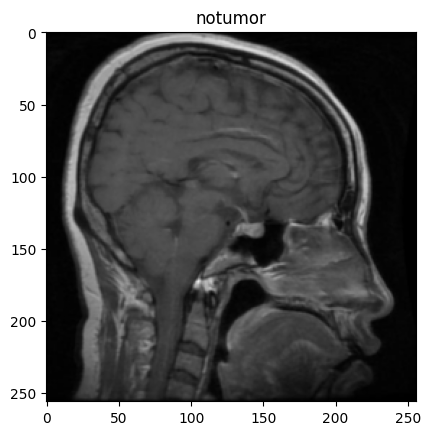

In [ ]:
# @title Dataset Generation
#TODO - Verify labels correspond to classes
data_transf = transforms.Compose([
transforms.Resize((256, 256)),
transforms.ToTensor()])
import matplotlib.pyplot as plt
TrainingDataset = ImageFolder(root='./Training/', transform=data_transf)#, transform=torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms)
TrainingLoader = DataLoader(TrainingDataset, batch_size=10, shuffle=True)
ValidationDataset = ImageFolder(root='./Validation/', transform=data_transf)#, transform=torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms)
ValidationLoader = DataLoader(ValidationDataset, batch_size=10, shuffle=True)
for batch_number , (images, labels) in enumerate(TrainingLoader):
  print(batch_number, labels)
  plt.imshow(torch.moveaxis(images[0], 0, -1))
  plt.title(classes[labels[0]])
  plt.show()
  break

In [ ]:
# Cross Entropy Loss for categorization
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(Classifier.parameters(), lr=0.005, momentum=.9)

def one_epoch(epoch_index):
  current_loss = 0
  running_loss = 0

  for i, data in enumerate(TrainingLoader):
    inputs, labels = data
    inputs = inputs.to('cuda')
    labels = labels.to('cuda')

    optimizer.zero_grad()
    outputs = Classifier(inputs)

    loss = loss_fn(outputs, labels)
    loss.backward()

    optimizer.step()

    current_loss += loss.item()
    running_loss += loss.item()
    if i % 10 == 9:
      print(f'Epoch {epoch_index + 1}, Batch {i + 1}, Loss: {current_loss / 10:.3f}')
      current_loss = 0.0

  print(f'Epoch {epoch_index + 1}, Total Loss: {running_loss}')
  running_loss = 0
  print('Validating...')
  for i, data in enumerate(ValidationLoader):
    inputs, labels = data
    inputs = inputs.to('cuda')
    labels = labels.to('cuda')
    outputs = Classifier(inputs)
    loss = loss_fn(outputs, labels)
    running_loss += loss.item()
  print(f'Epoch{epoch_index + 1}, Validation Loss: {running_loss}')

In [ ]:
for i in range(0,100):
  one_epoch(i)



Epoch 1, Batch 10, Loss: 0.292
Epoch 1, Batch 20, Loss: 0.200
Epoch 1, Batch 30, Loss: 0.240
Epoch 1, Batch 40, Loss: 0.481
Epoch 1, Batch 50, Loss: 0.479
Epoch 1, Batch 60, Loss: 0.327
Epoch 1, Batch 70, Loss: 0.327
Epoch 1, Batch 80, Loss: 0.377
Epoch 1, Batch 90, Loss: 0.440
Epoch 1, Batch 100, Loss: 0.454
Epoch 1, Batch 110, Loss: 0.333
Epoch 1, Batch 120, Loss: 0.343
Epoch 1, Batch 130, Loss: 0.286
Epoch 1, Batch 140, Loss: 0.257
Epoch 1, Batch 150, Loss: 0.363
Epoch 1, Batch 160, Loss: 0.552
Epoch 1, Batch 170, Loss: 0.282
Epoch 1, Batch 180, Loss: 0.200
Epoch 1, Batch 190, Loss: 0.211
Epoch 1, Batch 200, Loss: 0.274
Epoch 1, Batch 210, Loss: 0.300
Epoch 1, Batch 220, Loss: 0.204
Epoch 1, Batch 230, Loss: 0.225
Epoch 1, Batch 240, Loss: 0.276
Epoch 1, Batch 250, Loss: 0.347
Epoch 1, Batch 260, Loss: 0.284
Epoch 1, Batch 270, Loss: 0.299
Epoch 1, Batch 280, Loss: 0.178
Epoch 1, Batch 290, Loss: 0.207
Epoch 1, Batch 300, Loss: 0.233
Epoch 1, Batch 310, Loss: 0.148
Epoch 1, Batch 32

KeyboardInterrupt: ignored